# Random forest

1. Loading data...
Dataset loaded with 23852 rows and 16 columns.

2. Cleaning and preprocessing data...
Dropped 5429 rows with missing values.

3. Defining features and target...
Target variable: 'Valid Landslide'
Features used for modeling: ['CURVATURE', 'TWI', 'SLOPE_deg', 'DEM', 'LANDCOVER_CODE', 'ASPECT_sin', 'ASPECT_cos']

4. Splitting data into training and testing sets...
Training set size: 12896 samples
Testing set size: 5527 samples

5. Training the Random Forest model...
Model training complete.

6. Evaluating the model...
Out-of-Bag Score: 0.8590
Test Set Accuracy: 0.8634

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      2005
           1       0.87      0.92      0.90      3522

    accuracy                           0.86      5527
   macro avg       0.86      0.84      0.85      5527
weighted avg       0.86      0.86      0.86      5527

Confusion matrix plot saved as 'confusion_matrix.png'

7.

/tmp/ipython-input-1140608005.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')



Feature importance plot saved as 'feature_importance.png'


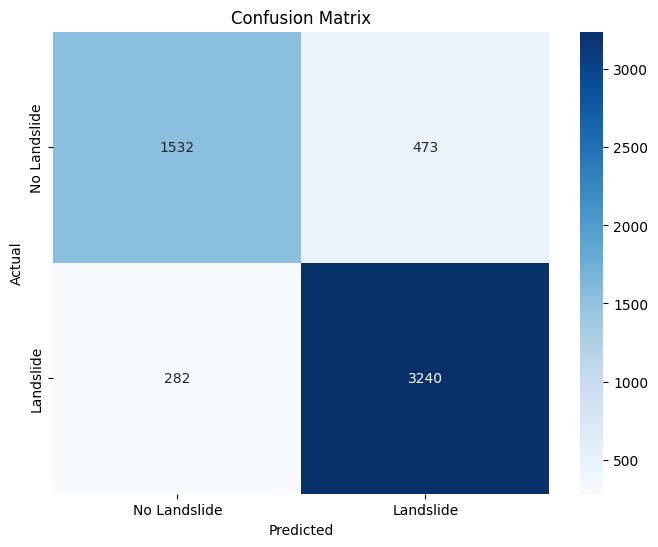

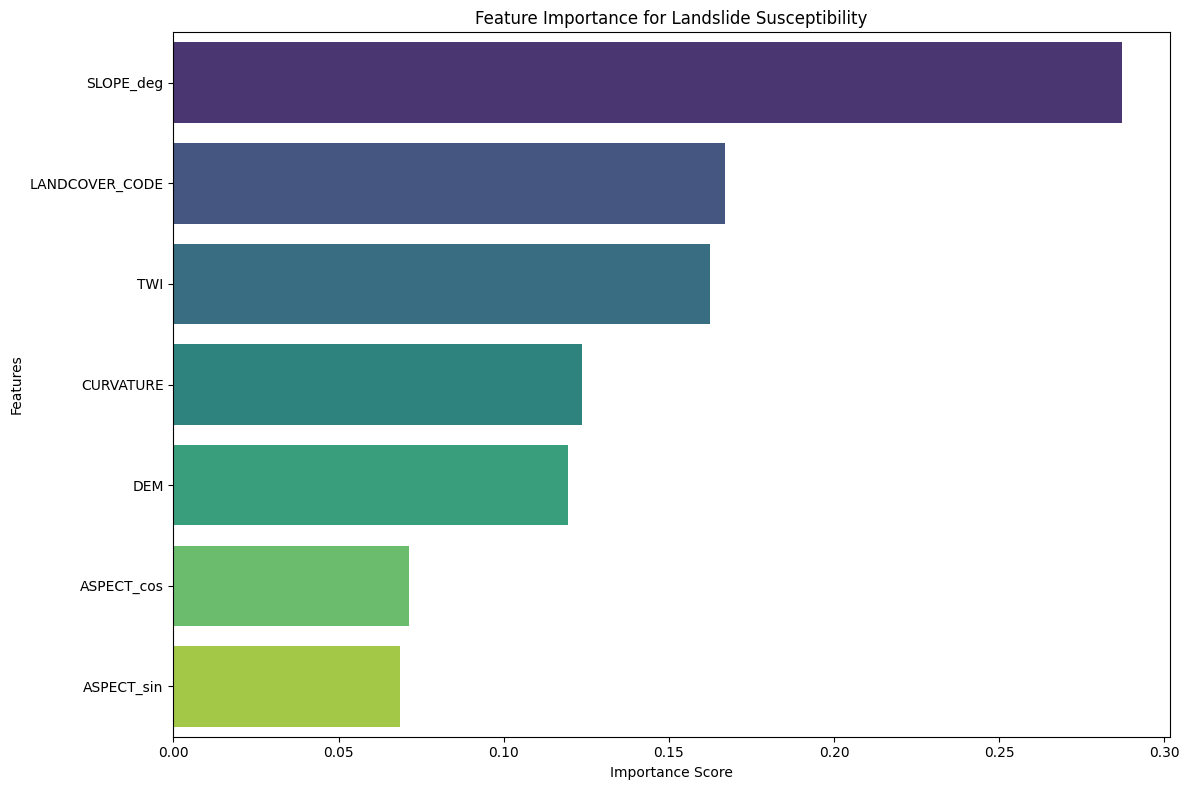

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def build_landslide_model(filepath):
    """
    Loads landslide data, trains a Random Forest model, evaluates it,
    and visualizes feature importances.

    Args:
        filepath (str): The path to the landslide CSV file.

    Returns:
        tuple: A tuple containing the trained model and the list of feature columns.
    """
    try:
        # 1. Load the dataset
        print("1. Loading data...")
        df = pd.read_csv(filepath)
        print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

        # 2. Data Cleaning and Preprocessing
        print("\n2. Cleaning and preprocessing data...")

        # Drop identifier and potentially leaky columns
        df.drop(columns=['ID', 'Area Maximum', 'Latitude', 'Longitude'], inplace=True, errors='ignore')

        # Drop redundant or less useful feature representations
        df.drop(columns=['SLOPE_deg.1', 'ASPECT_deg', 'ASPECT_rad', 'SLOPE_rad'], inplace=True, errors='ignore')

        # Handle missing values by dropping rows with any nulls
        initial_rows = len(df)
        df.dropna(inplace=True)
        print(f"Dropped {initial_rows - len(df)} rows with missing values.")

        if df.empty:
            print("No data left after cleaning. Exiting.")
            return None, None

        # 3. Feature Selection
        print("\n3. Defining features and target...")
        target = 'Valid Landslide'
        features = [col for col in df.columns if col != target]

        X = df[features]
        y = df[target]

        print(f"Target variable: '{target}'")
        print(f"Features used for modeling: {features}")

        if y.nunique() < 2:
            print("The target variable has only one class. Cannot train a classifier.")
            return None, None

        # 4. Data Splitting
        print("\n4. Splitting data into training and testing sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        print(f"Training set size: {len(X_train)} samples")
        print(f"Testing set size: {len(X_test)} samples")

        # 5. Model Training
        print("\n5. Training the Random Forest model...")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        print("Model training complete.")

        # 6. Model Evaluation
        print("\n6. Evaluating the model...")
        y_pred = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")
        print(f"Test Set Accuracy: {accuracy:.4f}\n")
        print("Classification Report:\n", report)

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Landslide', 'Landslide'],
                    yticklabels=['No Landslide', 'Landslide'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.savefig('confusion_matrix.png')
        print("Confusion matrix plot saved as 'confusion_matrix.png'")


        # 7. Feature Importance
        print("\n7. Analyzing feature importance...")
        importances = rf_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print("Top 5 most important features:")
        print(feature_importance_df.head())

        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title('Feature Importance for Landslide Susceptibility')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        print("\nFeature importance plot saved as 'feature_importance.png'")

        return rf_model, features

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None


model, features = build_landslide_model('landslides_with_variables2.csv')

## Susceptibility prediction

In [2]:
def predict_susceptibility(model, new_data, feature_columns):
    """
    Predicts landslide susceptibility for a new area.

    Args:
        model: The trained RandomForest model.
        new_data (pd.DataFrame): A DataFrame with data for the new area(s).
                                 Must contain all the feature_columns.
        feature_columns (list): The list of feature names the model was trained on.
    """
    if model is None or feature_columns is None:
        print("Model is not trained. Cannot make predictions.")
        return

    # Ensure the new data has the correct columns in the correct order
    try:
        data_for_prediction = new_data[feature_columns]
    except KeyError as e:
        print(f"Error: The new data is missing a required column: {e}")
        return

    # Use predict_proba to get the susceptibility score
    # It returns probabilities for [class 0, class 1]
    # We want the probability of class 1 (Landslide)
    susceptibility_scores = model.predict_proba(data_for_prediction)[:, 1]

    for i, score in enumerate(susceptibility_scores):
        print(f"\nLocation {i+1}:")
        print(f"  > Landslide Susceptibility Score: {score:.4f}")

        # Categorize the risk based on the score
        if score < 0.2:
            assessment = "Very Low risk"
        elif score < 0.4:
            assessment = "Low risk"
        elif score < 0.6:
            assessment = "Moderate risk"
        elif score < 0.8:
            assessment = "High risk"
        else:
            assessment = "Very High risk"

        print(f"  > Assessment: {assessment} of landslide.")





# Create a sample DataFrame for two new areas we want to test.
# In a real scenario, you would get this data from a GIS analysis of the new area.
new_areas_data = pd.DataFrame({
    #                [Area 1, Area 2]
    'CURVATURE':     [1.5, 0.1],
    'TWI':           [4.8, 8.0],
    'SLOPE_deg':     [25.0, 5.0],
    'DEM':           [50.0, 120.0],
    'LANDCOVER_CODE':[4, 1],
    'ASPECT_sin':    [-0.7, 0.5],
    'ASPECT_cos':    [-0.7, -0.86],
})


# Step 3: Use the trained model to predict the susceptibility for the new areas
predict_susceptibility(model, new_areas_data, features)




Location 1:
  > Landslide Susceptibility Score: 0.9600
  > Assessment: Very High risk of landslide.

Location 2:
  > Landslide Susceptibility Score: 0.1400
  > Assessment: Very Low risk of landslide.
